In [3]:
# Dependencies
from bs4 import BeautifulSoup #Python Web scraping library
import requests # library to handle requests
import json # library to handle JSON files
import xml 
import pandas as pd #Python library data manipulation and analysis
import numpy as np # library for vectorized computation
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Convert an address into latitude and longitude values
# Install the missing module 'geopy' in the python installation using "pip install geopy"
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# backend for rendering plots within the browser
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Install folium
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Download and explore NYC boroughs and neighborhoods

In [4]:
# Download the JSON
# Data available at https://geo.nyu.edu/catalog/nyu_2451_34572
!wget -q -O 'NYC_data.json' https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json
print('Data downloaded!')

Data downloaded!


In [5]:
# Load and Explore JSON
with open('NYC_data.json') as json_data:
    NYC_data = json.load(json_data)

All the relevant data is in the features key, which is basically a list of the neighborhoods. So, define a new variable that includes this data.

In [6]:
neighborhoods_data = NYC_data['features']

In [7]:
# Tranform the data into a pandas dataframe
# define the dataframe columns
column_names = ['Neighborhood', 'Borough', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
# Fill the data frame
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Neighborhood,Borough,Latitude,Longitude
0,Wakefield,Bronx,40.894705,-73.847201
1,Co-op City,Bronx,40.874294,-73.829939
2,Eastchester,Bronx,40.887556,-73.827806
3,Fieldston,Bronx,40.895437,-73.905643
4,Riverdale,Bronx,40.890834,-73.912585


In [9]:
# Append borough to neighborhood in order to create list of unique items. 
# This is required since there are some neighborhoods that have the same name but are present in different boroughs.
neighborhoods['Neighborhood with Borough'] = neighborhoods.Neighborhood.astype(str).str.cat(neighborhoods.Borough.astype(str), sep=' * ')
neighborhoods.head()

,Neighborhood,Borough,Latitude,Longitude,Neighborhood with Borough
0,Wakefield,Bronx,40.894705,-73.847201,Wakefield * Bronx
1,Co-op City,Bronx,40.874294,-73.829939,Co-op City * Bronx
2,Eastchester,Bronx,40.887556,-73.827806,Eastchester * Bronx
3,Fieldston,Bronx,40.895437,-73.905643,Fieldston * Bronx
4,Riverdale,Bronx,40.890834,-73.912585,Riverdale * Bronx


In [10]:
# Drop 'Neighborhood' and 'Borough' columns since these will not be needed individually
neighborhood_with_borough = neighborhoods.drop(['Neighborhood', 'Borough'], axis=1)
neighborhood_with_borough.head()

,Latitude,Longitude,Neighborhood with Borough
0,40.894705,-73.847201,Wakefield * Bronx
1,40.874294,-73.829939,Co-op City * Bronx
2,40.887556,-73.827806,Eastchester * Bronx
3,40.895437,-73.905643,Fieldston * Bronx
4,40.890834,-73.912585,Riverdale * Bronx


In [11]:
# Move Neighborhood with Borough column to the first position
cols = neighborhood_with_borough.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood with Borough')))
neighborhood_with_borough = neighborhood_with_borough.reindex(columns= cols)
neighborhood_with_borough

,Neighborhood with Borough,Latitude,Longitude
0,Wakefield * Bronx,40.894705,-73.847201
1,Co-op City * Bronx,40.874294,-73.829939
2,Eastchester * Bronx,40.887556,-73.827806
3,Fieldston * Bronx,40.895437,-73.905643
4,Riverdale * Bronx,40.890834,-73.912585
5,Kingsbridge * Bronx,40.881687,-73.902818
6,Marble Hill * Manhattan,40.876551,-73.910660
7,Woodlawn * Bronx,40.898273,-73.867315
8,Norwood * Bronx,40.877224,-73.879391
9,Williamsbridge * Bronx,40.881039,-73.857446


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [13]:
# Get the latitude and longitude values of New York City
address = 'New York City, NY'

geolocator = Nominatim(user_agent="BattleOfNeighborhoods_NYC")
location = geolocator.geocode(address)
latitudeNYC = location.latitude
longitudeNYC = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitudeNYC, longitudeNYC))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [14]:
# Create a map of New York to show the neighborhoods using latitude and longitude values
map_NewYork = folium.Map(location=[latitudeNYC, longitudeNYC], zoom_start=10)

# Add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork)  
    
map_NewYork

In [15]:
# Define Foursquare Credentials and Version - Gmail
Client_ID = "UOCPWCX0NBFMDC2J24V14U5WKRNPQVJNN2KVSB22AB4KDASA"
Client_Secret = "2LIJFRM1DI0NG4YL5LT1O2FQQUWZWRBVMWXTQAMT5XQQX0KT"
VERSION = '20190315'

In [16]:
# Create the URL
radius = 750 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    Client_ID, 
    Client_Secret, 
    VERSION, 
    latitudeNYC, 
    longitudeNYC, 
    radius, 
    LIMIT)

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c9926d74434b961193182bc'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'East Village',
  'headerFullLocation': 'East Village, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 237,
  'suggestedBounds': {'ne': {'lat': 40.737611906750004,
    'lng': -73.97826485905313},
   'sw': {'lat': 40.72411189325, 'lng': -73.99604674094687}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '3fd66200f964a5203de41ee3',
       'name': 'Sake Bar Decibel',
       'location': {'address': '240 E 9th St',
        'crossStreet': 'btwn 2nd & 3rd Ave.',
        'lat': 40.729416284697756,
        'lng':

In [18]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.delivery.id', 'venue.delivery.provider.icon.name',
       'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes', 'venue.delivery.provider.name',
       'venue.delivery.url', 'venue.id', 'venue.location.address',
       'venue.location.cc', 'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues["venue.categories"][1]

[{'id': '4bf58dd8d48988d142941735',
  'name': 'Asian Restaurant',
  'pluralName': 'Asian Restaurants',
  'shortName': 'Asian',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
   'suffix': '.png'},
  'primary': True}]

In [21]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# Clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Sake Bar Decibel,Sake Bar,40.729416,-73.987745
1,Momofuku Ssäm Bar,Asian Restaurant,40.731711,-73.985571
2,Han Dynasty,Chinese Restaurant,40.732130,-73.988090
3,Hi-Collar - ハイカラ (Hi-Collar),Coffee Shop,40.729449,-73.985918
4,Casey Rubber Stamp,Arts & Crafts Store,40.729962,-73.985098
5,Mudspot,Café,40.729082,-73.986750
6,Still House,Jewelry Store,40.729111,-73.986711
7,Cha-An Teahouse 茶菴,Tea Room,40.729577,-73.988036
8,Sundaes and Cones,Ice Cream Shop,40.730886,-73.989506
9,Kiehl's,Cosmetics Shop,40.732682,-73.987281


In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    count = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        count = count + 1
        print("----"+str(count)+"----Neighborhood = "+name+"----")    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_ID, 
            Client_Secret, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

#         if count == 2:
#             break
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
NYC_venues = getNearbyVenues(names = neighborhood_with_borough['Neighborhood with Borough'],
                                   latitudes = neighborhood_with_borough['Latitude'],
                                   longitudes = neighborhood_with_borough['Longitude'])

----1----Neighborhood = Wakefield * Bronx----
----2----Neighborhood = Co-op City * Bronx----
----3----Neighborhood = Eastchester * Bronx----
----4----Neighborhood = Fieldston * Bronx----
----5----Neighborhood = Riverdale * Bronx----
----6----Neighborhood = Kingsbridge * Bronx----
----7----Neighborhood = Marble Hill * Manhattan----
----8----Neighborhood = Woodlawn * Bronx----
----9----Neighborhood = Norwood * Bronx----
----10----Neighborhood = Williamsbridge * Bronx----
----11----Neighborhood = Baychester * Bronx----
----12----Neighborhood = Pelham Parkway * Bronx----
----13----Neighborhood = City Island * Bronx----
----14----Neighborhood = Bedford Park * Bronx----
----15----Neighborhood = University Heights * Bronx----
----16----Neighborhood = Morris Heights * Bronx----
----17----Neighborhood = Fordham * Bronx----
----18----Neighborhood = East Tremont * Bronx----
----19----Neighborhood = West Farms * Bronx----
----20----Neighborhood = High  Bridge * Bronx----
----21----Neighborhood = M

----160----Neighborhood = Briarwood * Queens----
----161----Neighborhood = Jamaica Center * Queens----
----162----Neighborhood = Oakland Gardens * Queens----
----163----Neighborhood = Queens Village * Queens----
----164----Neighborhood = Hollis * Queens----
----165----Neighborhood = South Jamaica * Queens----
----166----Neighborhood = St. Albans * Queens----
----167----Neighborhood = Rochdale * Queens----
----168----Neighborhood = Springfield Gardens * Queens----
----169----Neighborhood = Cambria Heights * Queens----
----170----Neighborhood = Rosedale * Queens----
----171----Neighborhood = Far Rockaway * Queens----
----172----Neighborhood = Broad Channel * Queens----
----173----Neighborhood = Breezy Point * Queens----
----174----Neighborhood = Steinway * Queens----
----175----Neighborhood = Beechhurst * Queens----
----176----Neighborhood = Bay Terrace * Queens----
----177----Neighborhood = Edgemere * Queens----
----178----Neighborhood = Arverne * Queens----
----179----Neighborhood = Ro

In [24]:
print(NYC_venues.shape)

(14549, 7)


In [25]:
NYC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield * Bronx,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield * Bronx,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield * Bronx,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
3,Wakefield * Bronx,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield * Bronx,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant


In [26]:
NYC_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton * Bronx,33,33,33,33,33,33
Annadale * Staten Island,10,10,10,10,10,10
Arden Heights * Staten Island,9,9,9,9,9,9
Arlington * Staten Island,12,12,12,12,12,12
Arrochar * Staten Island,30,30,30,30,30,30
Arverne * Queens,18,18,18,18,18,18
Astoria * Queens,100,100,100,100,100,100
Astoria Heights * Queens,26,26,26,26,26,26
Auburndale * Queens,58,58,58,58,58,58


In [27]:
print('There are {} uniques categories.'.format(len(NYC_venues['Venue Category'].unique())))

There are 449 uniques categories.


In [28]:
# one hot encoding
NYC_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NYC_onehot['Neighborhood'] = NYC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]
NYC_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,

In [29]:
NYC_onehot.shape

(14549, 449)

In [30]:
NYC_grouped = NYC_onehot.groupby('Neighborhood').mean().reset_index()
NYC_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School

In [31]:
NYC_grouped.shape

(306, 449)

In [32]:
num_top_venues = 10
count = 0
for hood in NYC_grouped['Neighborhood']:
    count = count + 1
    print("----"+str(count)+"----"+hood+"----")
    temp = NYC_grouped[NYC_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1----Allerton * Bronx----
                  venue  freq
0            Donut Shop  0.12
1        Sandwich Place  0.09
2           Supermarket  0.06
3           Bus Station  0.06
4                  Bank  0.06
5           Pizza Place  0.06
6  Fast Food Restaurant  0.06
7              Pharmacy  0.06
8        Clothing Store  0.03
9     Mobile Phone Shop  0.03


----2----Annadale * Staten Island----
                           venue  freq
0                    Pizza Place   0.3
1                     Restaurant   0.2
2                 Cosmetics Shop   0.1
3                     Sports Bar   0.1
4                  Train Station   0.1
5                          Diner   0.1
6                   Dance Studio   0.1
7            Rental Car Location   0.0
8  Paper / Office Supplies Store   0.0
9                      Pet Store   0.0


----3----Arden Heights * Staten Island----
                venue  freq
0       Garden Center  0.11
1            Bus Stop  0.11
2       Deli / Bodega  0.11
3            P

               venue  freq
0  Recreation Center  0.11
1           Bus Stop  0.11
2     Baseball Field  0.11
3   Department Store  0.11
4               Park  0.11
5               Café  0.11
6       Burger Joint  0.11
7         Theme Park  0.11
8     Discount Store  0.11
9       Perfume Shop  0.00


----29----Boerum Hill * Brooklyn----
                 venue  freq
0                  Bar  0.07
1          Coffee Shop  0.06
2               Bakery  0.04
3  Arts & Crafts Store  0.03
4         Dance Studio  0.03
5    French Restaurant  0.03
6        Grocery Store  0.03
7            Gift Shop  0.03
8          Opera House  0.02
9              Theater  0.02


----30----Borough Park * Brooklyn----
                         venue  freq
0                  Pizza Place  0.14
1                         Bank  0.14
2                     Pharmacy  0.10
3                   Restaurant  0.07
4                   Kids Store  0.07
5                  Men's Store  0.03
6                Deli / Bodega  0.03
7  Easter

                  venue  freq
0    Spanish Restaurant  0.10
1              Bus Stop  0.10
2     Martial Arts Dojo  0.05
3        Sandwich Place  0.05
4  Gym / Fitness Center  0.05
5                   Gym  0.05
6            Bagel Shop  0.05
7        Clothing Store  0.05
8                  Park  0.05
9   Arts & Crafts Store  0.05


----53----Chinatown * Manhattan----
                 venue  freq
0   Chinese Restaurant  0.11
1  American Restaurant  0.04
2         Optical Shop  0.04
3         Cocktail Bar  0.04
4               Bakery  0.03
5       Ice Cream Shop  0.03
6         Noodle House  0.03
7                  Spa  0.03
8  Dumpling Restaurant  0.03
9          Coffee Shop  0.03


----54----City Island * Bronx----
                    venue  freq
0         Harbor / Marina  0.21
1  Thrift / Vintage Store  0.06
2                     Bar  0.06
3      Seafood Restaurant  0.06
4      Italian Restaurant  0.06
5           Grocery Store  0.03
6      Spanish Restaurant  0.03
7          History Mu

                  venue  freq
0    Chinese Restaurant  0.09
1    Italian Restaurant  0.09
2         Deli / Bodega  0.07
3                   Spa  0.07
4                  Bank  0.04
5      Sushi Restaurant  0.04
6   Shanghai Restaurant  0.04
7  Fast Food Restaurant  0.02
8        Ice Cream Shop  0.02
9         Train Station  0.02


----76----Downtown * Brooklyn----
                  venue  freq
0          Burger Joint  0.04
1           Coffee Shop  0.04
2                   Spa  0.03
3        Sandwich Place  0.03
4           Pizza Place  0.03
5  Gym / Fitness Center  0.02
6    Chinese Restaurant  0.02
7          Cocktail Bar  0.02
8               Theater  0.02
9                   Bar  0.02


----77----Dumbo * Brooklyn----
                 venue  freq
0                 Park  0.09
1          Coffee Shop  0.07
2  American Restaurant  0.06
3       Scenic Lookout  0.04
4   Italian Restaurant  0.03
5            Bookstore  0.03
6       Ice Cream Shop  0.03
7                  Bar  0.03
8         

                venue  freq
0         Coffee Shop  0.07
1               Hotel  0.05
2                 Gym  0.04
3          Steakhouse  0.04
4           Wine Shop  0.04
5                Park  0.04
6                 Bar  0.03
7                Café  0.03
8  Italian Restaurant  0.03
9      Sandwich Place  0.03


----99----Flatbush * Brooklyn----
                  venue  freq
0  Caribbean Restaurant  0.13
1           Pizza Place  0.06
2                Lounge  0.06
3           Coffee Shop  0.06
4          Cocktail Bar  0.06
5     Indian Restaurant  0.06
6    Mexican Restaurant  0.06
7                   Gym  0.03
8         Grocery Store  0.03
9           High School  0.03


----100----Flatiron * Manhattan----
                           venue  freq
0            American Restaurant  0.04
1           Gym / Fitness Center  0.04
2        New American Restaurant  0.04
3                            Gym  0.04
4            Japanese Restaurant  0.03
5                    Yoga Studio  0.03
6  Vegetarian /

                venue  freq
0         Pizza Place  0.14
1            Pharmacy  0.09
2                 Bar  0.09
3  Italian Restaurant  0.09
4      Cosmetics Shop  0.05
5      Ice Cream Shop  0.05
6       Grocery Store  0.05
7  Spanish Restaurant  0.05
8      Sandwich Place  0.05
9       Train Station  0.05


----123----Greenpoint * Brooklyn----
               venue  freq
0                Bar  0.08
1       Cocktail Bar  0.05
2        Coffee Shop  0.05
3        Pizza Place  0.04
4             Bakery  0.04
5               Café  0.04
6        Yoga Studio  0.03
7        Record Shop  0.03
8  Polish Restaurant  0.03
9     Sandwich Place  0.03


----124----Greenridge * Staten Island----
                  venue  freq
0      Asian Restaurant  0.11
1  Gym / Fitness Center  0.06
2                 Trail  0.06
3           Coffee Shop  0.06
4              Pharmacy  0.06
5         Shopping Mall  0.06
6            Bagel Shop  0.06
7        Ice Cream Shop  0.06
8      Video Game Store  0.06
9  Fast Food

                       venue  freq
0                 Donut Shop  0.10
1          Indian Restaurant  0.07
2  Latin American Restaurant  0.05
3          Mobile Phone Shop  0.05
4        Fried Chicken Joint  0.05
5           Department Store  0.05
6       Caribbean Restaurant  0.05
7                   Pharmacy  0.05
8             Clothing Store  0.05
9         Chinese Restaurant  0.05


----147----Kensington * Brooklyn----
                  venue  freq
0       Thai Restaurant  0.07
1         Grocery Store  0.07
2           Pizza Place  0.07
3              Pharmacy  0.04
4        Ice Cream Shop  0.04
5        Sandwich Place  0.04
6                Bakery  0.04
7  Fast Food Restaurant  0.04
8                  Café  0.04
9                   Spa  0.02


----148----Kew Gardens * Queens----
                venue  freq
0  Chinese Restaurant  0.09
1          Donut Shop  0.05
2         Pizza Place  0.05
3                 Bar  0.05
4       Deli / Bodega  0.05
5               Diner  0.03
6       Groc

                 venue  freq
0          Pizza Place  0.10
1        Deli / Bodega  0.08
2                Diner  0.08
3   Chinese Restaurant  0.08
4    Mobile Phone Shop  0.05
5                 Bank  0.05
6        Grocery Store  0.05
7  Peruvian Restaurant  0.03
8               Bakery  0.03
9             Pharmacy  0.03


----174----Melrose * Bronx----
                  venue  freq
0           Pizza Place  0.11
1              Pharmacy  0.08
2           Bus Station  0.06
3           Supermarket  0.06
4    Mexican Restaurant  0.05
5            Donut Shop  0.05
6     Mobile Phone Shop  0.05
7  Fast Food Restaurant  0.03
8  Gym / Fitness Center  0.03
9        Discount Store  0.03


----175----Middle Village * Queens----
               venue  freq
0             Bakery  0.06
1     Discount Store  0.06
2        Pizza Place  0.06
3              Track  0.03
4     Sandwich Place  0.03
5     Cosmetics Shop  0.03
6        Event Space  0.03
7      Grocery Store  0.03
8  Mobile Phone Shop  0.03
9      

                venue  freq
0         Pizza Place  0.11
1         Bus Station  0.08
2    Sushi Restaurant  0.05
3                Pool  0.05
4  Italian Restaurant  0.05
5  Chinese Restaurant  0.05
6      Sandwich Place  0.05
7        Burger Joint  0.03
8          Bagel Shop  0.03
9                Bank  0.03


----200----North Side * Brooklyn----
                           venue  freq
0                    Coffee Shop  0.05
1                    Yoga Studio  0.04
2            American Restaurant  0.04
3                    Pizza Place  0.04
4              French Restaurant  0.03
5                            Bar  0.03
6                       Wine Bar  0.03
7  Vegetarian / Vegan Restaurant  0.03
8      South American Restaurant  0.02
9                    Beer Garden  0.02


----201----Norwood * Bronx----
                  venue  freq
0           Pizza Place  0.09
1    Chinese Restaurant  0.08
2              Pharmacy  0.05
3         Deli / Bodega  0.05
4                  Park  0.05
5     Mobil

                 venue  freq
0          Pizza Place  0.33
1           Bagel Shop  0.17
2     Sushi Restaurant  0.17
3             Pharmacy  0.17
4       Ice Cream Shop  0.17
5   Photography Studio  0.00
6            Pet Store  0.00
7          Pet Service  0.00
8             Pet Café  0.00
9  Peruvian Restaurant  0.00


----222----Prospect Heights * Brooklyn----
                     venue  freq
0                      Bar  0.07
1       Mexican Restaurant  0.04
2                Wine Shop  0.04
3          Thai Restaurant  0.04
4              Coffee Shop  0.04
5  New American Restaurant  0.03
6                    Plaza  0.03
7             Gourmet Shop  0.03
8                   Bakery  0.03
9                 Beer Bar  0.03


----223----Prospect Lefferts Gardens * Brooklyn----
                  venue  freq
0  Caribbean Restaurant  0.12
1           Pizza Place  0.06
2                Bakery  0.05
3                  Café  0.05
4          Liquor Store  0.04
5         Grocery Store  0.04
6        

                  venue  freq
0  Caribbean Restaurant  0.11
1   Fried Chicken Joint  0.11
2              Pharmacy  0.11
3    Spanish Restaurant  0.06
4            Donut Shop  0.06
5  Fast Food Restaurant  0.06
6           Supermarket  0.06
7         Train Station  0.06
8           Pizza Place  0.06
9                  Park  0.06


----244----Rossville * Staten Island----
            venue  freq
0     Pizza Place  0.20
1      Bagel Shop  0.13
2    Climbing Gym  0.07
3      Donut Shop  0.07
4             Bar  0.07
5     Event Space  0.07
6        Pharmacy  0.07
7  Ice Cream Shop  0.07
8     Dry Cleaner  0.07
9   Grocery Store  0.07


----245----Roxbury * Queens----
                  venue  freq
0         Boat or Ferry  0.12
1               Theater  0.12
2         Deli / Bodega  0.06
3            Public Art  0.06
4       Harbor / Marina  0.06
5                 Beach  0.06
6  Fast Food Restaurant  0.06
7        Baseball Field  0.06
8           Pizza Place  0.06
9        Scenic Lookout  0.06

                 venue  freq
0          Pizza Place  0.08
1  American Restaurant  0.08
2               Market  0.08
3        Grocery Store  0.08
4       Sandwich Place  0.08
5             Bus Stop  0.08
6   Salon / Barbershop  0.08
7    Convenience Store  0.08
8             Pharmacy  0.08
9           Bagel Shop  0.08


----270----Sunnyside Gardens * Queens----
                       venue  freq
0                Pizza Place  0.07
1                        Bar  0.07
2          Korean Restaurant  0.04
3        American Restaurant  0.03
4              Grocery Store  0.03
5                Coffee Shop  0.03
6           Sushi Restaurant  0.03
7                 Food Truck  0.03
8                       Park  0.03
9  Latin American Restaurant  0.02


----271----Sunset Park * Brooklyn----
                       venue  freq
0                Pizza Place  0.10
1         Mexican Restaurant  0.10
2                     Bakery  0.07
3                       Bank  0.05
4              Grocery Store  0.05
5 

                       venue  freq
0                 Donut Shop  0.08
1       Fast Food Restaurant  0.08
2             Sandwich Place  0.06
3                Pizza Place  0.06
4                   Pharmacy  0.06
5                      Diner  0.06
6                        Bar  0.04
7              Metro Station  0.04
8  Latin American Restaurant  0.02
9                Supermarket  0.02


----295----Westerleigh * Staten Island----
                      venue  freq
0         Convenience Store  0.06
1      Fast Food Restaurant  0.06
2  Mediterranean Restaurant  0.06
3        Chinese Restaurant  0.06
4      Gym / Fitness Center  0.03
5            Ice Cream Shop  0.03
6                  Pharmacy  0.03
7                Bagel Shop  0.03
8                       Gym  0.03
9                      Bank  0.03


----296----Whitestone * Queens----
                venue  freq
0  Italian Restaurant  0.18
1                 Bar  0.18
2       Deli / Bodega  0.09
3              Garden  0.09
4         Fish Mark

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NYC_grouped['Neighborhood']

for ind in np.arange(NYC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NYC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton * Bronx,Donut Shop,Sandwich Place,Supermarket,Bus Station,Fast Food Restaurant,Pharmacy,Pizza Place,Bank,Fried Chicken Joint,Dessert Shop
1,Annadale * Staten Island,Pizza Place,Restaurant,Cosmetics Shop,Dance Studio,Diner,Train Station,Sports Bar,Zoo,Farm,Fast Food Restaurant
2,Arden Heights * Staten Island,Pharmacy,Garden Center,Home Service,Bus Stop,Pizza Place,Food,Coffee Shop,Elementary School,Deli / Bodega,Factory
3,Arlington * Staten Island,Bus Stop,Polish Restaurant,Grocery Store,Home Service,Coffee Shop,Business Service,Boat or Ferry,American Restaurant,Intersection,Snack Place
4,Arrochar * Staten Island,Bus Stop,Pizza Place,Deli / Bodega,Italian Restaurant,Beach,Cosmetics Shop,Playground,Sandwich Place,Sculpture Garden,Outdoors & Recreation


#### Run k-means to cluster the neighborhood into k clusters

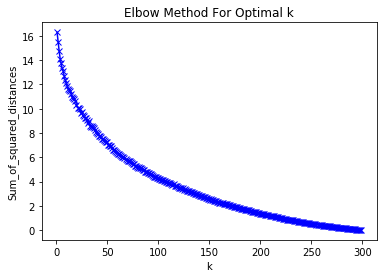

In [35]:
# Determine the optimal number of clusters for k-means clustering using elbow methods
Sum_of_squared_distances = []
K = range(1,300)
NYC_grouped_clustering = NYC_grouped.drop('Neighborhood', 1)

for kClusters in K:
    kmeans = KMeans(n_clusters = kClusters, random_state = 0).fit(NYC_grouped_clustering)
    #print(kClusters)
    #print(kmeans.inertia_)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
# Plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Since there are 306 neighborhoods and even k = 300 does not yield a well-defined elbow, for the sake of simplicity we will assume that for this exercise k = 5

In [36]:
# set number of clusters
# Using k-means to cluster the neighborhood into 4 clusters.
kclusters = 5
NYC_grouped_clustering = NYC_grouped.drop('Neighborhood', 1)
NYC_grouped_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NYC_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 3, 3, 3, 3, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 3, 2, 2, 0, 3, 1, 1,
       0, 0, 2, 2, 0, 0, 0, 3, 0, 0, 2, 0, 2, 3, 2, 0, 0, 1, 0, 2, 3, 1,
       1, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 3, 2, 0, 0, 1, 1, 2,
       0, 0, 2, 0, 2, 3, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 2, 3, 2,
       0, 2, 2, 2, 0, 0, 0, 2, 2, 3, 2, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2, 2,
       1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 0,
       0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 3, 2, 2, 3, 2, 2, 2, 3,
       0, 0, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 0, 4, 3, 0, 0, 3, 2, 0, 2,
       2, 0, 2, 2, 3, 1, 2, 0, 1, 2, 0, 3, 0, 2, 0, 1, 2, 2, 2, 0, 0, 2,
       2, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0,
       1, 2, 0, 1, 3, 2, 4, 0, 3, 3, 0, 3, 1, 0, 2, 3, 0, 1, 0, 1, 0, 2,
       1, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 0, 0, 2, 2,
       0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 3, 0, 2,

In [37]:
neighborhood_with_borough

,Neighborhood with Borough,Latitude,Longitude
0,Wakefield * Bronx,40.894705,-73.847201
1,Co-op City * Bronx,40.874294,-73.829939
2,Eastchester * Bronx,40.887556,-73.827806
3,Fieldston * Bronx,40.895437,-73.905643
4,Riverdale * Bronx,40.890834,-73.912585
5,Kingsbridge * Bronx,40.881687,-73.902818
6,Marble Hill * Manhattan,40.876551,-73.910660
7,Woodlawn * Bronx,40.898273,-73.867315
8,Norwood * Bronx,40.877224,-73.879391
9,Williamsbridge * Bronx,40.881039,-73.857446


In [38]:
NYC_merged = neighborhood_with_borough

# add clustering labels
NYC_merged['Cluster Labels'] = kmeans.labels_

# merge NYC_grouped with NYC_data to add latitude/longitude for each neighborhood
NYC_merged = NYC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on ='Neighborhood with Borough')

NYC_merged.head()

,Neighborhood with Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield * Bronx,40.894705,-73.847201,1,Caribbean Restaurant,Fried Chicken Joint,Ice Cream Shop,Gas Station,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Donut Shop,Sandwich Place,Supermarket
1,Co-op City * Bronx,40.874294,-73.829939,2,Accessories Store,Fried Chicken Joint,Fast Food Restaurant,Mattress Store,Music Venue,Mexican Restaurant,Electronics Store,Bagel Shop,Coffee Shop,Seafood Restaurant
2,Eastchester * Bronx,40.887556,-73.827806,3,Caribbean Restaurant,Fast Food Restaurant,Diner,Bus Station,Cosmetics Shop,Grocery Store,Bowling Alley,Furniture / Home Store,Burger Joint,Sporting Goods Shop
3,Fieldston * Bronx,40.895437,-73.905643,3,Plaza,Art Gallery,River,Home Service,Park,Café,Filipino Restaurant,Event Service,Event Space,Exhibit
4,Riverdale * Bronx,40.890834,-73.912585,3,Pizza Place,Mexican Restaurant,Playground,Bagel Shop,Diner,Bank,Japanese Restaurant,Mobile Phone Shop,Park,Tapas Restaurant


In [39]:
# create map
map_clusters = folium.Map(location=[latitudeNYC, longitudeNYC], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(NYC_merged['Latitude'], NYC_merged['Longitude'], NYC_merged['Neighborhood with Borough'], NYC_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']


In [40]:
df1 = NYC_merged.loc[NYC_merged['Cluster Labels'] == 0,NYC_merged.columns[[0] + list(range(5, NYC_merged.shape[1]))]]
df1.head()

,Neighborhood with Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Marble Hill * Manhattan,Pizza Place,Spanish Restaurant,Bar,Mexican Restaurant,Supermarket,Shoe Store,Coffee Shop,Discount Store,Bank
8,Norwood * Bronx,Chinese Restaurant,Deli / Bodega,Pharmacy,Park,Spanish Restaurant,Fast Food Restaurant,Supermarket,Mobile Phone Shop,Mexican Restaurant
10,Baychester * Bronx,Miscellaneous Shop,Discount Store,Department Store,Coffee Shop,Supermarket,Electronics Store,Sandwich Place,Breakfast Spot,Bagel Shop
11,Pelham Parkway * Bronx,Bakery,Sandwich Place,Pizza Place,Chinese Restaurant,Cosmetics Shop,Donut Shop,Coffee Shop,Pharmacy,Check Cashing Service
12,City Island * Bronx,Italian Restaurant,Seafood Restaurant,Thrift / Vintage Store,Bar,Japanese Restaurant,Art Gallery,Park,Smoke Shop,Bank


In [41]:
df2 = NYC_merged.loc[NYC_merged['Cluster Labels'] == 1,NYC_merged.columns[[0] + list(range(5, NYC_merged.shape[1]))]]
df2.head()

,Neighborhood with Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield * Bronx,Fried Chicken Joint,Ice Cream Shop,Gas Station,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Donut Shop,Sandwich Place,Supermarket
13,Bedford Park * Bronx,Supermarket,Pizza Place,Chinese Restaurant,Diner,Mexican Restaurant,Sandwich Place,Food Truck,Spanish Restaurant,Donut Shop
14,University Heights * Bronx,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Spanish Restaurant,Auto Dealership,Laundromat,Bank,Bakery,Pharmacy
34,Belmont * Bronx,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Sandwich Place,Mobile Phone Shop,Donut Shop,Liquor Store,Coffee Shop
42,Pelham Gardens * Bronx,Bus Station,Spanish Restaurant,Deli / Bodega,Pharmacy,Grocery Store,Bank,Martial Arts Dojo,Pet Store,Historic Site


In [42]:
df3 = NYC_merged.loc[NYC_merged['Cluster Labels'] == 2,NYC_merged.columns[[0] + list(range(5, NYC_merged.shape[1]))]]
df3.head()

,Neighborhood with Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City * Bronx,Fried Chicken Joint,Fast Food Restaurant,Mattress Store,Music Venue,Mexican Restaurant,Electronics Store,Bagel Shop,Coffee Shop,Seafood Restaurant
7,Woodlawn * Bronx,Pub,Bar,Rental Car Location,Italian Restaurant,Pizza Place,Bank,Diner,Train Station,Bakery
9,Williamsbridge * Bronx,Spa,Pharmacy,Pizza Place,Supermarket,Spanish Restaurant,Nightclub,Seafood Restaurant,Soup Place,Donut Shop
17,East Tremont * Bronx,Bank,Sandwich Place,Shoe Store,Mobile Phone Shop,Supermarket,Fried Chicken Joint,Fast Food Restaurant,Check Cashing Service,Breakfast Spot
19,High Bridge * Bronx,Pizza Place,Spanish Restaurant,Sandwich Place,Nightclub,Gym,Chinese Restaurant,Park,Track,Donut Shop


In [43]:
df4 = NYC_merged.loc[NYC_merged['Cluster Labels'] == 3,NYC_merged.columns[[0] + list(range(5, NYC_merged.shape[1]))]]
df4.head()

,Neighborhood with Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester * Bronx,Fast Food Restaurant,Diner,Bus Station,Cosmetics Shop,Grocery Store,Bowling Alley,Furniture / Home Store,Burger Joint,Sporting Goods Shop
3,Fieldston * Bronx,Art Gallery,River,Home Service,Park,Café,Filipino Restaurant,Event Service,Event Space,Exhibit
4,Riverdale * Bronx,Mexican Restaurant,Playground,Bagel Shop,Diner,Bank,Japanese Restaurant,Mobile Phone Shop,Park,Tapas Restaurant
5,Kingsbridge * Bronx,Pizza Place,Mexican Restaurant,Diner,Supermarket,Donut Shop,Sandwich Place,Coffee Shop,Bakery,Trail
37,Pelham Bay * Bronx,Sandwich Place,Bakery,Salon / Barbershop,Gym / Fitness Center,Fast Food Restaurant,Pharmacy,Diner,Donut Shop,Bank


In [44]:
df5 = NYC_merged.loc[NYC_merged['Cluster Labels'] == 4,NYC_merged.columns[[0] + list(range(5, NYC_merged.shape[1]))]]
df5.head()

,Neighborhood with Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
190,Belle Harbor * Queens,Deli / Bodega,Spa,Italian Restaurant,Donut Shop,Boutique,Bus Stop,Mexican Restaurant,Chinese Restaurant,Bakery
248,Noho * Manhattan,Coffee Shop,Cocktail Bar,Japanese Restaurant,Sushi Restaurant,Hotel,American Restaurant,French Restaurant,Seafood Restaurant,Art Gallery


In [45]:
clusters = pd.DataFrame({"Cluster1":df1["Neighborhood with Borough"],
                       "Cluster2":df2["Neighborhood with Borough"],
                       "Cluster3":df3["Neighborhood with Borough"],
                       "Cluster4":df4["Neighborhood with Borough"],
                       "Cluster5":df5["Neighborhood with Borough"]})

In [46]:
clusters = clusters.replace(np.nan, '', regex=True)

In [47]:
clusters

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5
0,,Wakefield * Bronx,,,
1,,,Co-op City * Bronx,,
2,,,,Eastchester * Bronx,
3,,,,Fieldston * Bronx,
4,,,,Riverdale * Bronx,
5,,,,Kingsbridge * Bronx,
6,Marble Hill * Manhattan,,,,
7,,,Woodlawn * Bronx,,
8,Norwood * Bronx,,,,
9,,,Williamsbridge * Bronx,,


In [48]:
new_NYC = NYC_merged.set_index("Neighborhood with Borough", drop=True)
new_NYC.head()

,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood with Borough,,,,,,,,,,,,,
Wakefield * Bronx,40.894705,-73.847201,1,Caribbean Restaurant,Fried Chicken Joint,Ice Cream Shop,Gas Station,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Donut Shop,Sandwich Place,Supermarket
Co-op City * Bronx,40.874294,-73.829939,2,Accessories Store,Fried Chicken Joint,Fast Food Restaurant,Mattress Store,Music Venue,Mexican Restaurant,Electronics Store,Bagel Shop,Coffee Shop,Seafood Restaurant
Eastchester * Bronx,40.887556,-73.827806,3,Caribbean Restaurant,Fast Food Restaurant,Diner,Bus Station,Cosmetics Shop,Grocery Store,Bowling Alley,Furniture / Home Store,Burger Joint,Sporting Goods Shop
Fieldston * Bronx,40.895437,-73.905643,3,Plaza,Art Gallery,River,Home Service,Park,Café,Filipino Restaurant,Event Service,Event Space,Exhibit
Riverdale * Bronx,40.890834,-73.912585,3,Pizza Place,Mexican Restaurant,Playground,Bagel Shop,Diner,Bank,Japanese Restaurant,Mobile Phone Shop,Park,Tapas Restaurant


In [49]:
# Load NYC school, demography and rent data
NYC_school_demo_df = pd.read_csv("NYC Neighborhood School and Demography.csv")
NYC_school_demo_df.head()

,Neighborhood with Borough,School Rating,Population - White,Population - Black,Population - Asian,Population - Hispanic,Population - Hawaiian,Population - Indian,Average Rent
0,Wakefield * Bronx,5,50481.0,4369.0,4995.0,3278.0,924.0,991.0,2664.0
1,Co-op City * Bronx,10,19200.0,4479.0,4376.0,5702.0,996.0,815.0,2564.0
2,Eastchester * Bronx,7,14354.0,3788.0,5554.0,8710.0,682.0,617.0,5158.0
3,Fieldston * Bronx,5,24809.0,1257.0,4052.0,9772.0,171.0,997.0,3868.0
4,Riverdale * Bronx,10,43101.0,5624.0,3387.0,13538.0,136.0,409.0,4557.0


In [50]:
NYC_school_ratings = NYC_school_demo_df[['Neighborhood with Borough','School Rating']]

In [51]:
NYC_school_ratings.head()

,Neighborhood with Borough,School Rating
0,Wakefield * Bronx,5
1,Co-op City * Bronx,10
2,Eastchester * Bronx,7
3,Fieldston * Bronx,5
4,Riverdale * Bronx,10


In [52]:
NYC_neighborhood_population = NYC_school_demo_df[['Neighborhood with Borough', 'Population - White', 'Population - Black', 'Population - Asian', 'Population - Hispanic', 'Population - Hawaiian', 'Population - Indian']]

In [53]:
NYC_neighborhood_population.head()

,Neighborhood with Borough,Population - White,Population - Black,Population - Asian,Population - Hispanic,Population - Hawaiian,Population - Indian
0,Wakefield * Bronx,50481.0,4369.0,4995.0,3278.0,924.0,991.0
1,Co-op City * Bronx,19200.0,4479.0,4376.0,5702.0,996.0,815.0
2,Eastchester * Bronx,14354.0,3788.0,5554.0,8710.0,682.0,617.0
3,Fieldston * Bronx,24809.0,1257.0,4052.0,9772.0,171.0,997.0
4,Riverdale * Bronx,43101.0,5624.0,3387.0,13538.0,136.0,409.0


In [54]:
NYC_avg_rent = NYC_school_demo_df[['Neighborhood with Borough','Average Rent']]

In [55]:
NYC_avg_rent.head()

,Neighborhood with Borough,Average Rent
0,Wakefield * Bronx,2664.0
1,Co-op City * Bronx,2564.0
2,Eastchester * Bronx,5158.0
3,Fieldston * Bronx,3868.0
4,Riverdale * Bronx,4557.0


## Analysis

#### Rent Analysis

In [56]:
NYC_avg_rent.describe()

,Average Rent
count,307.000000
mean,3971.322476
std,1184.971852
min,1805.000000
25%,2974.500000
50%,4015.000000
75%,5044.000000
max,5977.000000


In [57]:
#Median
NYC_avg_rent['Average Rent'].median()

4015.0

In [58]:
#Mode
NYC_avg_rent['Average Rent'].mode()

0    1833.0
1    3281.0
2    3867.0
3    3985.0
4    3986.0
5    4441.0
6    4602.0
7    4833.0
8    5289.0
9    5420.0
dtype: float64

#### Binning of Average Rent

In [60]:
NYC_avg_rent_int = NYC_avg_rent.dropna().astype({'Average Rent': 'int64'}, copy=False)

Text(0.5,1,'Average Rent Bins')

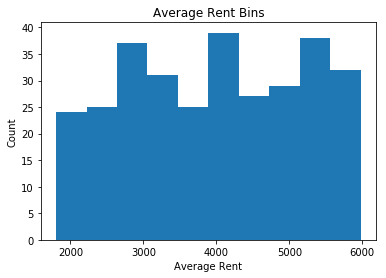

In [61]:
# The histogram of average rent, to see what the distribution looks like
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(NYC_avg_rent_int["Average Rent"])

# set x/y labels and plot title
plt.pyplot.xlabel("Average Rent")
plt.pyplot.ylabel("Count")
plt.pyplot.title("Average Rent Bins")

In [62]:
# binwidth = int((max(NYC_avg_rent_int['Average Rent']) - min(NYC_avg_rent_int['Average Rent']))/4)

#We build a bin array, with a minimum value to a maximum value, with bandwidth calculated above. 
#The bins will be values used to determine when one bin ends and another begins.
bins = np.linspace(min(NYC_avg_rent_int["Average Rent"]), max(NYC_avg_rent_int["Average Rent"]), 4)
bins

array([1805.        , 3195.66666667, 4586.33333333, 5977.        ])

In [63]:
NYC_avg_rent_int.head()

,Neighborhood with Borough,Average Rent
0,Wakefield * Bronx,2664
1,Co-op City * Bronx,2564
2,Eastchester * Bronx,5158
3,Fieldston * Bronx,3868
4,Riverdale * Bronx,4557


In [64]:
# bins = range(min(NYC_avg_rent_int['Average Rent']), max(NYC_avg_rent_int['Average Rent']), binwidth)
# group_names = ['Low', 'Medium', 'High']
# NYC_avg_rent_int['Binned Average Rent'] = pd.cut(NYC_avg_rent_int['Average Rent'], bins, labels = group_names)

group_names = ['Low', 'Medium', 'High']
NYC_avg_rent_int["Binned Average Rent"] = pd.cut(NYC_avg_rent_int["Average Rent"], bins, labels = group_names, include_lowest = True )

In [65]:
NYC_avg_rent_int

,Neighborhood with Borough,Average Rent,Binned Average Rent
0,Wakefield * Bronx,2664,Low
1,Co-op City * Bronx,2564,Low
2,Eastchester * Bronx,5158,High
3,Fieldston * Bronx,3868,Medium
4,Riverdale * Bronx,4557,Medium
5,Kingsbridge * Bronx,5490,High
6,Marble Hill * Manhattan,2775,Low
7,Woodlawn * Bronx,4687,High
8,Norwood * Bronx,4513,Medium
9,Williamsbridge * Bronx,4170,Medium


In [67]:
NYC_avg_rent_int["Binned Average Rent"].value_counts()

High      107
Medium    100
Low       100
Name: Binned Average Rent, dtype: int64

Text(0.5,1,'Average Rent Bins')

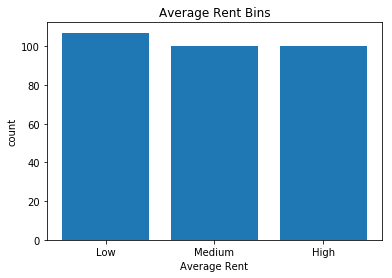

In [70]:
# Plot the distribution of each bin.

%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
pyplot.bar(group_names, NYC_avg_rent_int["Binned Average Rent"].value_counts())

# set x/y labels and plot title
plt.pyplot.xlabel("Average Rent")
plt.pyplot.ylabel("count")
plt.pyplot.title("Average Rent Bins")

##### Enter Preferred Rent Budget:

In [68]:
min_rent = input("Enter min monthly rent: ")

Enter min monthly rent: 3500


In [69]:
max_rent = input("Enter max monthly rent: ")

Enter max monthly rent: 3750


In [71]:
NYC_preferred_rent = NYC_avg_rent_int.loc[(NYC_avg_rent_int['Average Rent'] >= int(min_rent)) & (NYC_avg_rent_int['Average Rent'] <= int(max_rent))]

In [72]:
NYC_preferred_rent

,Neighborhood with Borough,Average Rent,Binned Average Rent
26,Soundview * Bronx,3750,Medium
49,Greenpoint * Brooklyn,3595,Medium
101,Washington Heights * Manhattan,3547,Medium
108,Yorkville * Manhattan,3714,Medium
122,Soho * Manhattan,3747,Medium
133,Howard Beach * Queens,3653,Medium
188,Laurelton * Queens,3639,Medium
189,Lefrak City * Queens,3524,Medium
194,Bellaire * Queens,3622,Medium
201,West Brighton * Staten Island,3589,Medium


#### Relationship between school rating and rent

In [74]:
NYC_schoolrating_rent = NYC_school_demo_df[['School Rating','Average Rent']]
NYC_schoolrating_rent.head()

,School Rating,Average Rent
0,5,2664.0
1,10,2564.0
2,7,5158.0
3,5,3868.0
4,10,4557.0


In [75]:
NYC_schoolrating_rent[["School Rating", "Average Rent"]].corr()

,School Rating,Average Rent
School Rating,1.000000,-0.042825
Average Rent,-0.042825,1.000000


/Users/arnabbasu1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 6192.229829187968)

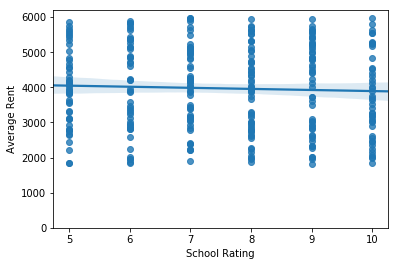

In [80]:
# School Rating as potential predictor variable of rent
sns.regplot(x = "School Rating", y = "Average Rent", data = NYC_schoolrating_rent)
plt.pyplot.ylim(0,)

For the given data, school rating does not seem like a good predictor of the rent at all since the regression line is close to horizontal. Also, the data points are very scattered and far from the fitted line, showing lots of variability. Therefore it is not a reliable variable.

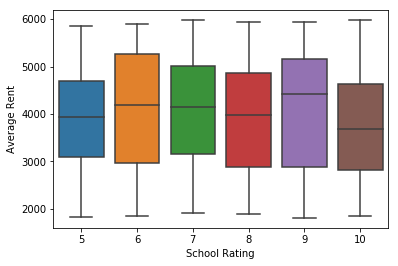

In [77]:
sns.boxplot(x = "School Rating", y = "Average Rent", data = NYC_schoolrating_rent)

In [81]:
NYC_neighborhood_population ["Total Population"] = NYC_neighborhood_population["Population - White"] + NYC_neighborhood_population["Population - Black"] + NYC_neighborhood_population["Population - Asian"] + NYC_neighborhood_population["Population - Hispanic"] + NYC_neighborhood_population["Population - Hawaiian"] + NYC_neighborhood_population["Population - Indian"]
NYC_neighborhood_population.head()

,Neighborhood with Borough,Population - White,Population - Black,Population - Asian,Population - Hispanic,Population - Hawaiian,Population - Indian,Total Population,Percentage of Indian Population
0,Wakefield * Bronx,50481.0,4369.0,4995.0,3278.0,924.0,991.0,65038.0,1.523725
1,Co-op City * Bronx,19200.0,4479.0,4376.0,5702.0,996.0,815.0,35568.0,2.291386
2,Eastchester * Bronx,14354.0,3788.0,5554.0,8710.0,682.0,617.0,33705.0,1.830589
3,Fieldston * Bronx,24809.0,1257.0,4052.0,9772.0,171.0,997.0,41058.0,2.428272
4,Riverdale * Bronx,43101.0,5624.0,3387.0,13538.0,136.0,409.0,66195.0,0.617871


In [82]:
NYC_neighborhood_population ["Percentage of Indian Population"] = (NYC_neighborhood_population["Population - Indian"] / NYC_neighborhood_population["Total Population"]) * 100
NYC_neighborhood_population.head()

,Neighborhood with Borough,Population - White,Population - Black,Population - Asian,Population - Hispanic,Population - Hawaiian,Population - Indian,Total Population,Percentage of Indian Population
0,Wakefield * Bronx,50481.0,4369.0,4995.0,3278.0,924.0,991.0,65038.0,1.523725
1,Co-op City * Bronx,19200.0,4479.0,4376.0,5702.0,996.0,815.0,35568.0,2.291386
2,Eastchester * Bronx,14354.0,3788.0,5554.0,8710.0,682.0,617.0,33705.0,1.830589
3,Fieldston * Bronx,24809.0,1257.0,4052.0,9772.0,171.0,997.0,41058.0,2.428272
4,Riverdale * Bronx,43101.0,5624.0,3387.0,13538.0,136.0,409.0,66195.0,0.617871


In [83]:
NYC_neighborhood_population = NYC_neighborhood_population.sort_values('Percentage of Indian Population', ascending=False)

In [84]:
NYC_neighborhood_population.head(10)

,Neighborhood with Borough,Population - White,Population - Black,Population - Asian,Population - Hispanic,Population - Hawaiian,Population - Indian,Total Population,Percentage of Indian Population
95,East Williamsburg * Brooklyn,11613.0,709.0,5085.0,5248.0,784.0,901.0,24340.0,3.701726
179,Neponsit * Queens,12388.0,1019.0,2020.0,7855.0,456.0,826.0,24564.0,3.362645
246,Bulls Head * Staten Island,13689.0,1528.0,5530.0,4717.0,325.0,874.0,26663.0,3.277951
204,South Beach * Staten Island,19330.0,2968.0,2616.0,2078.0,397.0,910.0,28299.0,3.215661
5,Kingsbridge * Bronx,16072.0,5878.0,789.0,6075.0,656.0,952.0,30422.0,3.129314
70,Park Slope * Brooklyn,10859.0,5418.0,3841.0,5442.0,297.0,819.0,26676.0,3.070175
176,Edgemere * Queens,13497.0,4508.0,775.0,14168.0,860.0,987.0,34795.0,2.836614
49,Greenpoint * Brooklyn,17526.0,6978.0,1705.0,1830.0,639.0,827.0,29505.0,2.802915
111,Upper West Side * Manhattan,10837.0,3965.0,5859.0,13652.0,738.0,996.0,36047.0,2.763059
19,High Bridge * Bronx,22134.0,5686.0,2540.0,3763.0,623.0,987.0,35733.0,2.762153


In [85]:
NYC_preferred_rent_school = pd.merge(NYC_school_ratings, NYC_preferred_rent, on = 'Neighborhood with Borough')

In [86]:
NYC_preferred_rent_school.head()

,Neighborhood with Borough,School Rating,Average Rent,Binned Average Rent
0,Soundview * Bronx,10,3750,Medium
1,Greenpoint * Brooklyn,5,3595,Medium
2,Washington Heights * Manhattan,5,3547,Medium
3,Yorkville * Manhattan,9,3714,Medium
4,Soho * Manhattan,8,3747,Medium


In [87]:
NYC_preferred_rent_school_population = pd.merge(NYC_preferred_rent_school, NYC_neighborhood_population[['Neighborhood with Borough','Percentage of Indian Population']],on='Neighborhood with Borough', how='left')

In [88]:
NYC_preferred_rent_school_population.head()

,Neighborhood with Borough,School Rating,Average Rent,Binned Average Rent,Percentage of Indian Population
0,Soundview * Bronx,10,3750,Medium,0.495543
1,Greenpoint * Brooklyn,5,3595,Medium,2.802915
2,Washington Heights * Manhattan,5,3547,Medium,1.830292
3,Yorkville * Manhattan,9,3714,Medium,0.334031
4,Soho * Manhattan,8,3747,Medium,2.307716


##### Enter minimum preferred school rating

In [89]:
min_school_rating = input("Enter the min required school rating: ")

Enter the min required school rating: 9


In [90]:
NYC_preferred_rent_school_population_filtered = NYC_preferred_rent_school_population.loc[(NYC_preferred_rent_school_population['Average Rent'] >= int(min_rent)) & (NYC_preferred_rent_school_population['Average Rent'] <= int(max_rent)) & (NYC_preferred_rent_school_population['School Rating'] >= int(min_school_rating))]

In [91]:
NYC_preferred_rent_school_population_filtered.shape

(7, 5)

In [92]:
NYC_preferred_rent_school_population_filtered.sort_values('Percentage of Indian Population', ascending=False)

,Neighborhood with Borough,School Rating,Average Rent,Binned Average Rent,Percentage of Indian Population
5,Howard Beach * Queens,10,3653,Medium,1.447054
10,Eltingville * Staten Island,9,3729,Medium,1.413067
8,Bellaire * Queens,9,3622,Medium,0.954466
12,Shore Acres * Staten Island,10,3694,Medium,0.827706
7,Lefrak City * Queens,10,3524,Medium,0.655047
0,Soundview * Bronx,10,3750,Medium,0.495543
3,Yorkville * Manhattan,9,3714,Medium,0.334031


In [93]:
NYC_compare_neighborhoods_list = NYC_preferred_rent_school_population_filtered["Neighborhood with Borough"].tolist()

In [94]:
NYC_compare_neighborhoods_list

['Soundview * Bronx',
 'Yorkville * Manhattan',
 'Howard Beach * Queens',
 'Lefrak City * Queens',
 'Bellaire * Queens',
 'Eltingville * Staten Island',
 'Shore Acres * Staten Island']

In [95]:
Venue_column_names = NYC_compare_neighborhoods_list
Venue_comparison = new_NYC.T
Venue_comparison_final = Venue_comparison[Venue_column_names]
Venue_comparison_final

Neighborhood with Borough,Soundview * Bronx,Yorkville * Manhattan,Howard Beach * Queens,Lefrak City * Queens,Bellaire * Queens,Eltingville * Staten Island,Shore Acres * Staten Island
Latitude,40.821,40.7759,40.6542,40.7361,40.733,40.5422,40.6097
Longitude,-73.8657,-73.9471,-73.8381,-73.8625,-73.7389,-74.1643,-74.0667
Cluster Labels,0,3,1,0,3,2,0
1st Most Common Venue,Fried Chicken Joint,Italian Restaurant,Italian Restaurant,Clothing Store,Pizza Place,Sushi Restaurant,Italian Restaurant
2nd Most Common Venue,Fast Food Restaurant,Gym,Park,Bakery,Chinese Restaurant,Pizza Place,Deli / Bodega
3rd Most Common Venue,Deli / Bodega,Coffee Shop,Sandwich Place,Cosmetics Shop,Deli / Bodega,Bank,Bus Stop
4th Most Common Venue,Chinese Restaurant,Bar,Chinese Restaurant,Shoe Store,Convenience Store,Sandwich Place,Bar
5th Most Common Venue,Clothing Store,Mexican Restaurant,Bagel Shop,Fast Food Restaurant,Fast Food Restaurant,Pharmacy,Intersection
6th Most Common Venue,Breakfast Spot,Pizza Place,Sushi Restaurant,Coffee Shop,Italian Restaurant,Italian Restaurant,Gastropub
7th Most Common Venue,Pizza Place,Japanese Restaurant,Ice Cream Shop,Pizza Place,Moving Target,Diner,Furniture / Home Store


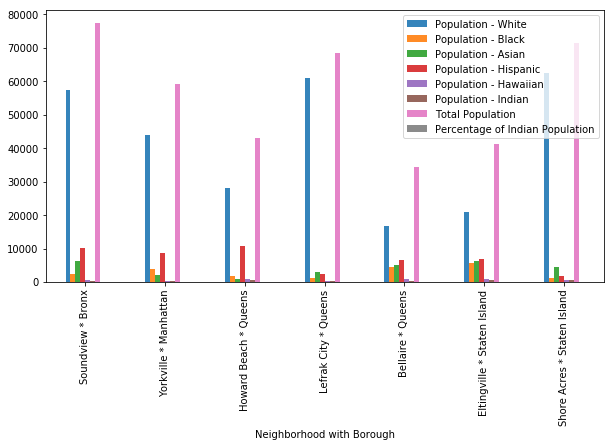

In [96]:
NYC_neighborhood_population = NYC_neighborhood_population.set_index("Neighborhood with Borough", drop=True)
Population_Comparison = NYC_neighborhood_population.loc[NYC_compare_neighborhoods_list]
Population_Comparison.plot(kind = 'bar', alpha = 0.90, figsize = (10,5))

In [97]:
Population_Comparison['Population - Indian']

Neighborhood with Borough
Soundview * Bronx              383.0
Yorkville * Manhattan          198.0
Howard Beach * Queens          623.0
Lefrak City * Queens           448.0
Bellaire * Queens              327.0
Eltingville * Staten Island    582.0
Shore Acres * Staten Island    592.0
Name: Population - Indian, dtype: float64

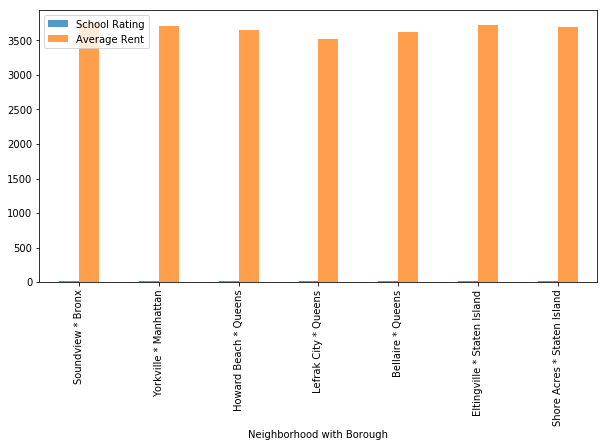

In [98]:
NYC_preferred_rent_school = NYC_preferred_rent_school.set_index("Neighborhood with Borough", drop = True)
School_rating_comparison = NYC_preferred_rent_school.loc[NYC_compare_neighborhoods_list]
School_rating_comparison.plot(kind = 'bar', alpha = 0.75, figsize=(10,5))

In [99]:
School_rating_comparison

,School Rating,Average Rent,Binned Average Rent
Neighborhood with Borough,,,
Soundview * Bronx,10,3750,Medium
Yorkville * Manhattan,9,3714,Medium
Howard Beach * Queens,10,3653,Medium
Lefrak City * Queens,10,3524,Medium
Bellaire * Queens,9,3622,Medium
Eltingville * Staten Island,9,3729,Medium
Shore Acres * Staten Island,10,3694,Medium


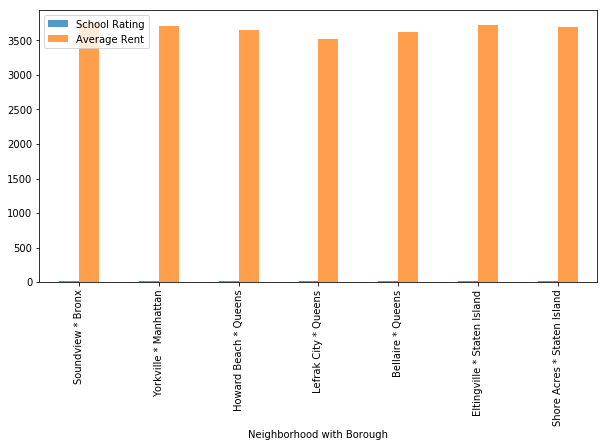

In [100]:
# NYC_avg_rent_int = NYC_avg_rent_int.set_index("Neighborhood with Borough", drop = True)
Avg_housing_price_comparison = NYC_preferred_rent_school.loc[NYC_compare_neighborhoods_list]
Avg_housing_price_comparison.plot(kind = 'bar',alpha = 0.75, figsize = (10,5));

## Conclusion